In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
w_list=[]
line_list=open("data//words.txt", "r").readlines()
for line in line_list:
    if line[0] == '#':
        continue
    if line.split(" ")[1] == "ok":
        w_list.append(line)

In [4]:
np.random.shuffle(w_list)

In [5]:
train_split=int(0.9*len(w_list))
validation_split=int(0.95*len(w_list))
train_set=w_list[:train_split]
validation_set=w_list[train_split:validation_split]
test_set=w_list[validation_split:]

In [6]:
print(len(train_set))
print(len(validation_set))
print(len(test_set))

86810
4823
4823


In [7]:
base_path="data//words"
def img_path_labels(sets):
    img_path=[]
    labels=[]
    
    for line in sets:
        name=line.strip()
        name=name.split(" ")[0]
        part1=name.split("-")[0]
        part2=name.split("-")[1]
        path=os.path.join(base_path, part1, part1 + "-" + part2, name +".png")
        label=line.split(" ")[-1]
        label=label.strip()
        
        if os.path.getsize(path):
            img_path.append(path)
            labels.append(label)
            
    return img_path, labels

train_img_path, train_label=img_path_labels(train_set)
validation_img_path, validation_label=img_path_labels(validation_set)
test_img_path, test_label=img_path_labels(test_set)

In [8]:
train_label[:10]

['looked',
 ',',
 '"',
 'Hahnemann',
 'observe',
 'ONLY',
 'Lord',
 'cent',
 'believe',
 '?']

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

char_set=set()
word_length=0
for label in train_label:
    for char in label:
        char_set.add(char)
        word_length=max(word_length, len(label))
        
print("Maximum word length=", word_length)       
print("vocabulary size: ", len(char_set))

char_to_int=StringLookup(vocabulary=list(char_set), mask_token=None)
int_to_char=StringLookup(vocabulary=char_to_int.get_vocabulary(), mask_token=None, invert=True)

def process_labels(labels):
    labels=tf.strings.unicode_split(labels, input_encoding="UTF-8")
    labels=char_to_int(labels)
    length=tf.shape(labels)[0]
    label_pad=word_length-length
    labels=tf.pad(labels, paddings=[[0, label_pad]], constant_values=99)
    return labels

Maximum word length= 21
vocabulary size:  78


In [10]:
w=128
h=32
def preprocess_image(img_path, img_size=(w, h)):
    img=tf.io.read_file(img_path)
    img=tf.image.decode_png(img, 1)
    img=tf.image.resize(img, size=(h,w), preserve_aspect_ratio=True)
    
    ht_pad=h-tf.shape(img)[0]
    w_pad=w-tf.shape(img)[1]
    
    if ht_pad % 2 == 0: 
        top_pad = bottom_pad = ht_pad // 2
    else:
        top_pad=(ht_pad // 2) + 1
        bottom_pad=ht_pad // 2
        
    if w_pad % 2 == 0:  
        left_pad=right_pad=w_pad // 2
    else:
        left_pad=(w_pad // 2) + 1
        right_pad=w_pad // 2
        
    img=tf.pad(img, paddings=[[top_pad, bottom_pad], [left_pad, right_pad], [0,0],],)
    img=tf.transpose(img, perm=[1, 0, 2])
    img=tf.image.flip_left_right(img)
    img=tf.cast(img, tf.float32) / 255.0
    return img

In [11]:
def img_label_processing(img_path, labels):
    img=preprocess_image(img_path)
    labels=process_labels(labels)
    return {"image":img, "label":labels}

def get_dataset(img_path, labels):
    ds=tf.data.Dataset.from_tensor_slices((img_path, labels)).map(img_label_processing,
                                                                  num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)

In [12]:
train_dataset=get_dataset(train_img_path, train_label)
validation_dataset=get_dataset(validation_img_path, validation_label)
test_dataset=get_dataset(test_img_path, test_label)

In [13]:
module=keras.layers

class CTC(module.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_function=keras.backend.ctc_batch_cost
        
    def call(self, actual_y, pred_y):
        batch_size =tf.cast(tf.shape(actual_y)[0], dtype="int64")
        pred_length =tf.cast(tf.shape(pred_y)[1], dtype="int64")
        actual_length =tf.cast(tf.shape(actual_y)[1], dtype="int64")
        
        pred_length=pred_length * tf.ones(shape=(batch_size, 1), dtype="int64")
        actual_length=actual_length * tf.ones(shape=(batch_size, 1), dtype="int64")
        
        loss=self.loss_function(actual_y, pred_y, pred_length, actual_length)
        self.add_loss(loss)
        
        return pred_y

In [14]:
def HTR_model():
    ip_image=keras.Input(shape=(w, h, 1), name="image")
    ip_label=module.Input(name="label", shape=(None,))
     
    X_train=module.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", 
                          padding="same", name="LayerI")(ip_image)
    X_train=module.MaxPooling2D((2, 2), name="poolI")(X_train)
    
 
    X_train=module.Conv2D(64, (3,3), activation="relu",kernel_initializer="he_normal",
                          padding="same" , name="LayerII")(X_train)
    X_train=module.MaxPooling2D((2, 2), name="poolII")(X_train)
    
    
    shape_change = ((w // 4), (h // 4) * 64)
    X_train=module.Reshape(target_shape=shape_change, name="Reshape")(X_train)
    X_train=module.Dense(64, activation="relu", name="DenseI")(X_train)
    X_train=module.Dropout(0.2)(X_train)
    
    X_train=module.Bidirectional(module.LSTM(128, return_sequences=True, dropout=0.25))(X_train)
    X_train=module.Bidirectional(module.LSTM(64, return_sequences=True, dropout=0.25))(X_train)
    X_train=module.Dense(len(char_to_int.get_vocabulary()) + 2, 
                        activation="softmax", name="DenseII")(X_train)
    
    output = CTC(name="ctc_loss")(ip_label, X_train)
    model=keras.models.Model(inputs=[ip_image, ip_label], outputs=output, name="HTR")
    
    optimizer=keras.optimizers.Adam()
    model.compile(optimizer=optimizer)
    
    return model

model=HTR_model()
model.summary()

Model: "HTR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 LayerI (Conv2D)                (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 poolI (MaxPooling2D)           (None, 64, 16, 32)   0           ['LayerI[0][0]']                 
                                                                                                  
 LayerII (Conv2D)               (None, 64, 16, 64)   18496       ['poolI[0][0]']                

In [15]:
n_epoch=15

model=HTR_model()
model_pred=keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="DenseII").output)
history=model.fit(train_dataset, validation_data=validation_dataset, epochs=n_epoch,)

Epoch 1/15
1357/1357 [==============================] - 587s 427ms/step - loss: 13.5758 - val_loss: 11.9288
Epoch 2/15
1357/1357 [==============================] - 340s 251ms/step - loss: 10.6998 - val_loss: 9.6022
Epoch 3/15
1357/1357 [==============================] - 340s 250ms/step - loss: 8.8842 - val_loss: 7.6538
Epoch 4/15
1357/1357 [==============================] - 364s 268ms/step - loss: 7.2968 - val_loss: 5.8647
Epoch 5/15
1357/1357 [==============================] - 347s 256ms/step - loss: 5.9024 - val_loss: 4.6829
Epoch 6/15
1357/1357 [==============================] - 345s 254ms/step - loss: 4.9847 - val_loss: 4.1082
Epoch 7/15
1357/1357 [==============================] - 345s 254ms/step - loss: 4.4070 - val_loss: 3.5330
Epoch 8/15
1357/1357 [==============================] - 347s 256ms/step - loss: 4.0237 - val_loss: 3.2462
Epoch 9/15
1357/1357 [==============================] - 346s 255ms/step - loss: 3.7209 - val_loss: 3.0954
Epoch 10/15
1357/1357 [====================

In [16]:
def decode_predictions(p):
    n_words=p.shape[0]
    n_alphabet=p.shape[1]
    word_len_arr=np.ones(n_words) * n_alphabet
    decoded_arr=keras.backend.ctc_decode(p, input_length=word_len_arr, greedy=True)[0][0][:, :word_length]
    
    output=[]
    for word in decoded_arr:
        if_alphabet=tf.math.not_equal(word, -1)
        alp_index=tf.where(if_alphabet)
        word=tf.gather(word, alp_index)
        decoded_alp=int_to_char(word)
        word=tf.strings.reduce_join(decoded_alp).numpy().decode("utf-8")
        output.append(word)
        
    return output     

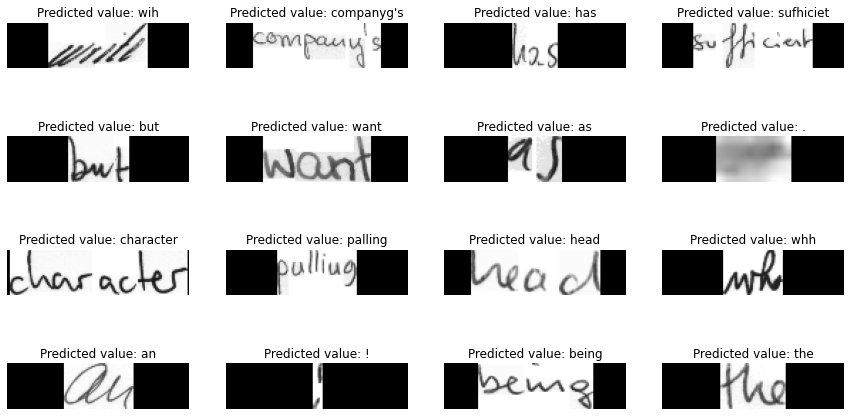

In [35]:
for batch in test_dataset.take(1):
    img=batch["image"]
    fig, axs=plt.subplots(4, 4, figsize=(15, 8))
    
    p=model_pred.predict(img)
    text=decode_predictions(p)
    
    for i in range(16):
        word_img=img[i]
        word_img=tf.image.flip_left_right(word_img)
        word_img=tf.transpose(word_img, perm=[1, 0, 2])
        word_img=(word_img * 255.0).numpy()
        word_img=word_img.clip(0, 255).astype(np.uint8)
        word_img=word_img[:, :, 0]
        
        name=f"Predicted value: {text[i]}"
        axs[i // 4, i % 4].imshow(word_img, cmap="gray")
        axs[i // 4, i % 4].set_title(name)
        axs[i // 4, i % 4].axis("off")
        
plt.show()